In [1]:
import pandas as pd

In [2]:
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM
from keras import Model
import matplotlib.pyplot as plt
import lightgbm as lgb
from math import sqrt

Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
from sklearn.preprocessing import MinMaxScaler
from numpy import concatenate

In [5]:
import numpy as np

In [6]:
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [7]:
def MAPE_List(y_true, y_pred): 
    return (y_true - y_pred) / y_true * 100

In [8]:
#首先在excel中做一些基础的处理，将数据多余的列清除
#读入原始数据
raw_data = pd.read_excel("weather_data.xlsx")

In [9]:
#查看数据头部情况
raw_data.head()

,date,high_temp,low_temp,weather,weekend,holiday,holiday2
0,2015-01-01,9,-2,晴,0,1,1
1,2015-01-02,15,0,晴转多云,0,1,1
2,2015-01-03,18,5,晴,1,1,1
3,2015-01-04,22,9,晴转多云,0,0,0
4,2015-01-05,13,5,小雨,0,0,0


In [10]:
#查看数据尾部情况
raw_data.tail()

,date,high_temp,low_temp,weather,weekend,holiday,holiday2
907,2017-06-26,27,22,小雨,0,0,0
908,2017-06-27,27,22,阵雨,0,0,0
909,2017-06-28,25,23,中雨,0,0,0
910,2017-06-29,28,23,阵雨,0,0,0
911,2017-06-30,32,25,小雨,0,0,0


In [11]:
#查看数据的统计信息
raw_data.describe()

,high_temp,low_temp,weekend,holiday,holiday2
count,912.000000,912.000000,912.000000,912.000000,912.000000
mean,21.343202,14.399123,0.268640,0.086623,0.317982
std,8.778127,8.438108,0.443496,0.281436,0.465948
min,-3.000000,-8.000000,0.000000,0.000000,0.000000
25%,14.000000,7.000000,0.000000,0.000000,0.000000
50%,23.000000,16.000000,0.000000,0.000000,0.000000
75%,28.000000,21.000000,1.000000,0.000000,1.000000
max,39.000000,31.000000,1.000000,1.000000,1.000000


In [12]:
#对可能的缺失值做ffill处理
raw_data.fillna(method= 'ffill', inplace=True)

In [13]:
#读入电力数据
y_raw = pd.read_csv("trade_day_dl.csv", index_col="DATETIME")

In [14]:
#去除无用的列
y_raw.drop("Y",axis=1,inplace=True)

In [15]:
#展示头部
y_raw.head()

,TOTAL_DL
DATETIME,
2015/1/1,77582045.48
2015/1/2,64616181.98
2015/1/3,69255859.03
2015/1/4,75443414.30
2015/1/5,77484576.85


In [16]:
#查看数据长度，发现和x不一致
len(y_raw)

1331

In [17]:
#缺失值处理
y_raw.fillna(method= 'ffill', inplace=True)

In [18]:
#选取912条数据使得和x同样长度
y_select = y_raw[:912]

In [19]:
#查看数据情况
y_select.head()

,TOTAL_DL
DATETIME,
2015/1/1,77582045.48
2015/1/2,64616181.98
2015/1/3,69255859.03
2015/1/4,75443414.30
2015/1/5,77484576.85


In [20]:
scaler_label = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_label.fit_transform(y_select)

In [21]:
y_scaled.shape

(912, 1)

In [22]:
#将weather列做处理，首先提取出可能的weather情况
weather_list = set(raw_data['weather'])

In [23]:
#共有65种
len(weather_list)

65

In [24]:
#建立labelEncoder
le = preprocessing.LabelEncoder()
le.fit(list(weather_list))
weather_list_encoded = le.transform(raw_data['weather']) 

In [25]:
weather_list_encoded

array([35, 36, 35, 36, 27, 29, 14, 36, 36, 14, 11, 43,  6, 42, 11, 14, 14,
       35, 11, 29, 35, 36, 36, 15, 32, 27, 27, 27, 57, 41, 41, 27, 27, 32,
       14, 36, 35, 11, 35, 35, 36, 36, 36, 36, 43, 42, 11, 35, 11, 27, 27,
       42, 23, 32, 27, 23, 28,  4, 29, 11, 32, 45, 10, 27, 42, 28, 32, 11,
       11, 14, 35, 37, 51, 25, 16, 51, 25, 44, 29, 11, 15, 11, 14, 13, 27,
       14, 36, 46, 42, 11, 39, 61, 42, 50, 46, 28, 32, 16, 42, 11, 11, 43,
       50, 35, 29, 35, 11, 46,  1, 42, 35, 11, 15, 14, 11, 15, 42, 15, 11,
       36, 28, 50, 11, 54, 44, 14, 11, 11, 11, 13, 21, 36, 16, 27,  5, 50,
       43,  7, 11, 14, 35, 39, 41, 41, 11, 41, 46, 41, 46, 54, 11, 11, 53,
       54, 46, 11, 11, 62, 20,  8, 33, 42, 11, 63,  3, 46, 46,  5,  7, 11,
       11,  3, 46, 11, 11, 11,  7,  8, 50, 11, 62, 21, 41, 41, 26,  3,  3,
        6, 46, 46, 24, 18, 50, 11, 36, 11, 15, 50, 11, 11, 11, 54, 26, 50,
       50, 11, 42, 35, 35, 35, 35, 35, 35, 14, 35, 35, 35, 36, 46,  3,  8,
       46, 54, 11, 50, 54

In [26]:
#将encoded weather放到原始数据集中
raw_data['weather_encoded'] = weather_list_encoded

In [27]:
#将index设置成日期，将原有的weather去除
raw_data.set_index("date",drop=True, inplace=True)
raw_data.drop(['weather'], axis =1, inplace =True)

In [28]:
#新的数据框
raw_data.head()

,high_temp,low_temp,weekend,holiday,holiday2,weather_encoded
date,,,,,,
2015-01-01,9,-2,0,1,1,35
2015-01-02,15,0,0,1,1,36
2015-01-03,18,5,1,1,1,35
2015-01-04,22,9,0,0,0,36
2015-01-05,13,5,0,0,0,27


In [29]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(np.array(raw_data['weather_encoded']).reshape(-1, 1))

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True)

In [30]:
weather_feature = enc.transform(np.array(raw_data['weather_encoded']).reshape(-1, 1)).todense()

In [31]:
data_without_weather = raw_data.drop(['weather_encoded'],axis=1)

In [32]:
matrix_without_weather = data_without_weather.values

In [33]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(matrix_without_weather)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [34]:
dataset

array([[0.28571429, 0.15384615, 0.        , 1.        , 1.        ],
       [0.42857143, 0.20512821, 0.        , 1.        , 1.        ],
       [0.5       , 0.33333333, 1.        , 1.        , 1.        ],
       ...,
       [0.66666667, 0.79487179, 0.        , 0.        , 0.        ],
       [0.73809524, 0.79487179, 0.        , 0.        , 0.        ],
       [0.83333333, 0.84615385, 0.        , 0.        , 0.        ]])

In [35]:
feature_all = concatenate((dataset, weather_feature),axis=1)

In [36]:
feature_all.shape

(912, 70)

In [37]:
#Train_Test_Split得到训练集和测试集
x_train, x_test, y_train, y_test, index_train, index_test = train_test_split(feature_all, y_scaled, raw_data, test_size = 0.1, random_state = 89)

In [38]:
x_train

matrix([[0.30952381, 0.30769231, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.9047619 , 0.92307692, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.71428571, 0.74358974, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.80952381, 0.69230769, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.80952381, 0.79487179, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.66666667, 0.58974359, 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [58]:
#训练XGBoost with feature scaling
xgb = XGBRegressor(learning_rate =0.05, n_estimators=1000, max_depth=8,
    min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
    nthread=4, scale_pos_weight=1, seed=27)
xgb.fit(x_train, y_train)
pred_xgb = xgb.predict(x_test)
rmse_xgb = sqrt(mean_squared_error(y_test, pred_xgb))
mape_xgb = MAPE(y_test, pred_xgb)
print('Test RMSE xgb: %.3f' %rmse_xgb)
print('Test MAPE xgb: %.3f' %mape_xgb)

#训练LightGBM
# train
gbm = lgb.LGBMRegressor(objective='regression',
                        num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=200)
gbm.fit(np.asarray(x_train), y_train)
# predict
y_pred = gbm.predict(np.asarray(x_test))
# eval
rmse_gbm = sqrt(mean_squared_error(y_test, y_pred))
mape_gbm = MAPE(y_test, y_pred)
print('Test RMSE lgb: %.3f' %rmse_gbm)
print('Test MAPE xgb: %.3f' %mape_gbm)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test RMSE xgb: 0.234
Test MAPE xgb: inf
Test RMSE lgb: 0.195
Test MAPE xgb: inf


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


matrix([[0.30952381, 0.30769231, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.9047619 , 0.92307692, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.71428571, 0.74358974, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.80952381, 0.69230769, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.80952381, 0.79487179, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.66666667, 0.58974359, 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [40]:
x_train.shape

(820, 70)

(820, 1, 70) (92, 1, 70)
Train on 820 samples, validate on 92 samples
Epoch 1/50
 - 2s - loss: 0.0951 - val_loss: 0.0412
Epoch 2/50
 - 2s - loss: 0.0352 - val_loss: 0.0386
Epoch 3/50
 - 2s - loss: 0.0338 - val_loss: 0.0380
Epoch 4/50
 - 2s - loss: 0.0331 - val_loss: 0.0378
Epoch 5/50
 - 2s - loss: 0.0327 - val_loss: 0.0377
Epoch 6/50
 - 2s - loss: 0.0322 - val_loss: 0.0376
Epoch 7/50
 - 2s - loss: 0.0319 - val_loss: 0.0375
Epoch 8/50
 - 2s - loss: 0.0315 - val_loss: 0.0374
Epoch 9/50
 - 2s - loss: 0.0311 - val_loss: 0.0374
Epoch 10/50
 - 2s - loss: 0.0307 - val_loss: 0.0374
Epoch 11/50
 - 2s - loss: 0.0303 - val_loss: 0.0374
Epoch 12/50
 - 2s - loss: 0.0299 - val_loss: 0.0376
Epoch 13/50
 - 2s - loss: 0.0295 - val_loss: 0.0378
Epoch 14/50
 - 2s - loss: 0.0291 - val_loss: 0.0380
Epoch 15/50
 - 2s - loss: 0.0287 - val_loss: 0.0383
Epoch 16/50
 - 2s - loss: 0.0284 - val_loss: 0.0387
Epoch 17/50
 - 2s - loss: 0.0281 - val_loss: 0.0391
Epoch 18/50
 - 2s - loss: 0.0278 - val_loss: 0.0395
Epo

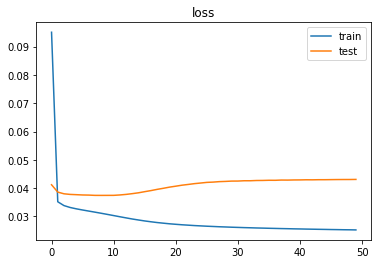

Test RMSE LSTMs: 0.208
Test MAPE LSTMs:inf


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [41]:
y_train_lstm = y_train
y_test_lstm = y_test
# reshape input to be 3D [samples, timesteps, features]
x_train_array = np.asarray(x_train)
x_test_array = np.asarray(x_test)
x_train_lstm = x_train_array.reshape((x_train_array.shape[0], 1, x_train_array.shape[1]))
x_test_lstm = x_test_array.reshape((x_test_array.shape[0], 1, x_test_array.shape[1]))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(x_train_lstm.shape,x_test_lstm.shape)
# design network
model = Sequential()
model.add(LSTM(8, input_shape=(x_train_lstm.shape[1], x_train_lstm.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(x_train_lstm, y_train_lstm, epochs=50, batch_size=1, validation_data=(x_test_lstm, y_test_lstm), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("loss")
plt.show()

#predict with LSTMs
yhat = model.predict(x_test_lstm)
# calculate RMSE
rmse = sqrt(mean_squared_error(y_test_lstm, yhat))
mape = MAPE(y_test_lstm, yhat)
print('Test RMSE LSTMs: %.3f' %rmse)
print('Test MAPE LSTMs:%.3f' %mape)

In [42]:
y_result_lstm = pd.DataFrame(index = index_test.index)
y_result_lstm['original'] = scaler_label.inverse_transform(y_test)
y_result_lstm['pred'] = scaler_label.inverse_transform(yhat)
y_result_lstm['lgbm'] = scaler_label.inverse_transform(y_pred.reshape(-1, 1))
y_result_lstm['lgbm'] = y_result_lstm['lgbm'].astype(int)

In [43]:
y_result_lstm.head()

,original,pred,lgbm
date,,,
2015-08-06,88157053.81,80914064.0,89999959
2015-05-06,85538242.40,84909616.0,87045362
2017-02-03,21419997.64,85701200.0,81401828
2016-04-27,85016925.27,82406280.0,85279964
2017-03-04,89932021.12,82327952.0,74965884


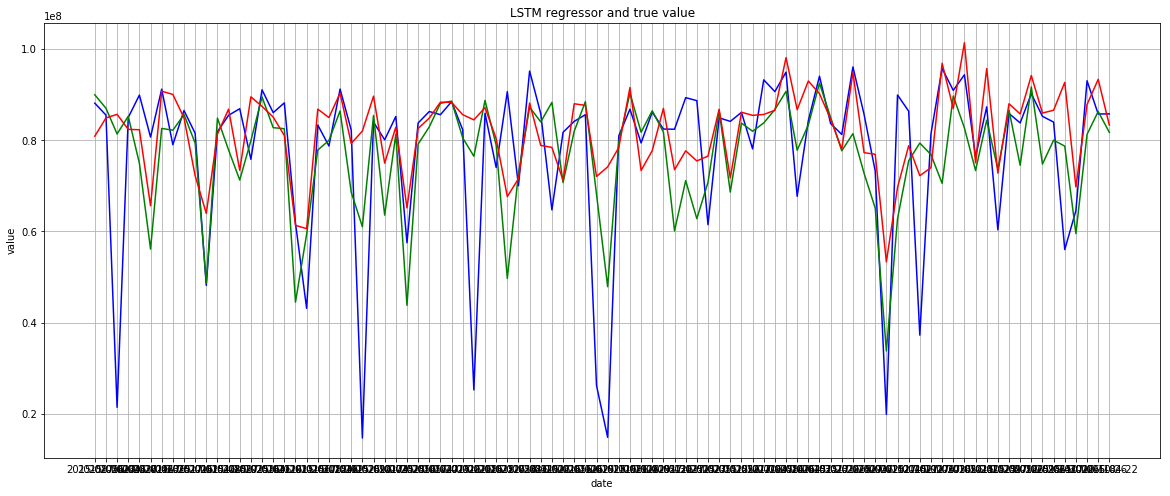

In [44]:
plt.figure(figsize=(20,8))
plt.plot(y_result_lstm.index, y_result_lstm['original'],c = 'blue')
plt.plot(y_result_lstm.index, y_result_lstm['lgbm'],c = 'green')
plt.plot(y_result_lstm.index, y_result_lstm['pred'],c = 'red')
plt.axis()
plt.title("LSTM regressor and true value")
plt.xlabel("date")
plt.ylabel("value")
plt.grid()
plt.savefig("2RegressionModel.png")
plt.show()

In [45]:
MAPE_lstm = MAPE_List( y_result_lstm['original'], y_result_lstm['pred'])

In [46]:
np.mean(np.abs(MAPE_lstm))

27.84478546314542

In [47]:
#春节期间，用电量大规模减少，但是本模型仅预测基于天气的，该数据不会因此被改变，因此春节期间的波动极大。
MAPE_lgbm = MAPE_List(y_result_lstm['original'], y_result_lstm['lgbm'])

In [48]:
np.mean(np.abs(MAPE_lgbm))

23.881077610918496

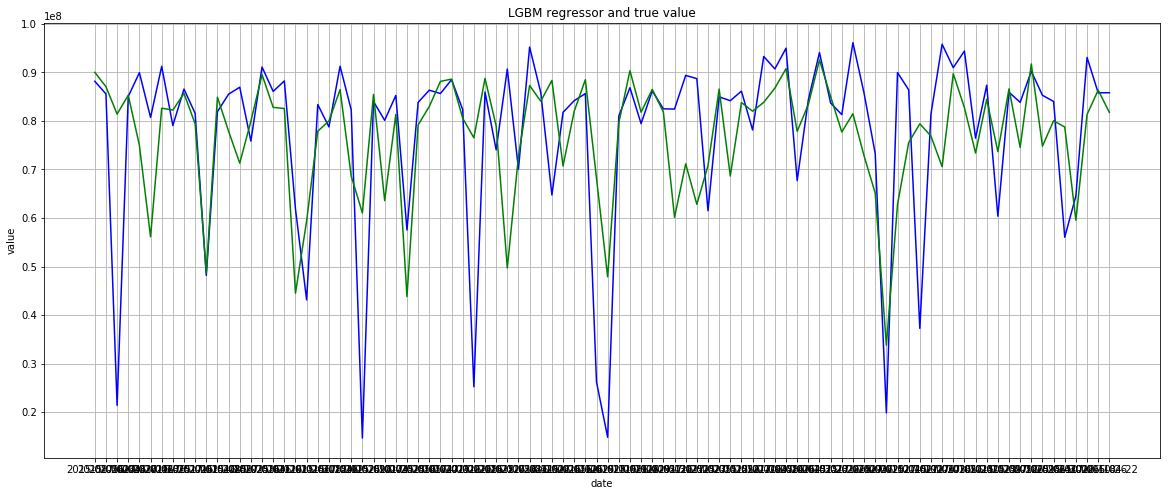

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.plot(y_result_lstm.index, y_result_lstm['original'],c = 'blue')
plt.plot(y_result_lstm.index, y_result_lstm['lgbm'],c = 'green')
plt.axis()
plt.title("LGBM regressor and true value")
plt.xlabel("date")
plt.ylabel("value")
plt.grid()
plt.show()


In [50]:
y_result_lstm['MAPE_lgbm'] = MAPE_lgbm
y_result_lstm['MAPE_lstm'] = MAPE_lstm

In [51]:
y_result_lstm.to_csv('test_result.csv')

In [52]:
y_result_lstm

,original,pred,lgbm,MAPE_lgbm,MAPE_lstm
date,,,,,
2015-08-06,88157053.81,80914064.0,89999959,-2.090480,8.216007
2015-05-06,85538242.40,84909616.0,87045362,-1.761925,0.734907
2017-02-03,21419997.64,85701200.0,81401828,-280.027250,-300.099017
2016-04-27,85016925.27,82406280.0,85279964,-0.309396,3.070736
2017-03-04,89932021.12,82327952.0,74965884,16.641611,8.455352
2016-01-13,80708116.70,65639688.0,56129437,30.453789,18.670277
2016-06-25,91230770.51,90789792.0,82616641,9.442132,0.483366
2016-06-27,79039369.64,90071096.0,82222342,-4.027072,-13.957255
2017-01-05,86547925.25,84937632.0,85650503,1.036908,1.860580
